Consider a non-linear multidimensional SDE

$$
\begin{aligned}
d X_1(t) &= X_2(t) dt, \\
d X_2(t) &= X_1(t) \, \big(\alpha - (X_1(t))^2\big) - X_2(t) dt + X_1(t) d W(t),
\end{aligned}
$$

The model above is called a modified Duffing-van der Pol model.

In this notebook, we show how to use the TME method to approximate the mean and covariance of the solution of the SDE above. 

Before we proceed, please make sure that you have the `tme` package installed together with `JAX`.

In [1]:
# Imports
import jax
import math
import numpy as np
import jax.numpy as jnp
import tme.base_jax as tme
import matplotlib.pyplot as plt
from jax import jit
from typing import Tuple

jax.config.update("jax_enable_x64", True)

First, let us write down the SDE coefficients

In [2]:
alp = 1.
q = 0.1

def drift(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.array([x[1],
                      x[0] * (alp - x[0] ** 2) - x[1]])

def dispersion(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.array([0., x[0]]) * math.sqrt(q)

Okay, next we can jit the functon `tme_m_cov` for fast computation.

In [3]:
@jit
def tme_m_cov(x: jnp.ndarray, dt: float) -> Tuple[jnp.ndarray, jnp.ndarray]:
    return tme.mean_and_cov(x=x, dt=dt, drift=drift, dispersion=dispersion, order=3)

Now we can call the function `tme_m_cov` to compute the mean and covariance.

In [4]:
# Initial value at t=0
x = jnp.array([0., -1])

# Time instances
num_time_steps = 100
T = np.linspace(0.01, 1, num_time_steps)

# Result containers
m_results = np.zeros((num_time_steps, 2))
cov_results = np.zeros((num_time_steps, 2, 2))

# Compute for t=0.01, ..., 1
# Note that you can do this loop more efficiently by using `vmap`. See how is this done in benes_jax.ipynb
for idx, t in enumerate(T):
    m_results[idx], cov_results[idx] = tme_m_cov(x, t)

Plot results

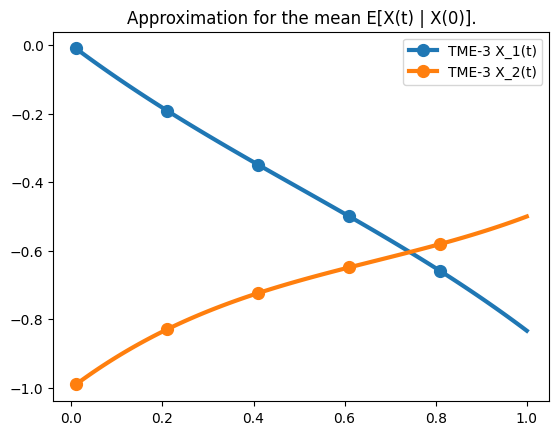

In [5]:
_ = plt.plot(T, m_results[:, 0],
             linewidth=3, marker='.', markevery=20, markersize=17,
             label='TME-3 X_1(t)')
_ = plt.plot(T, m_results[:, 1],
             linewidth=3, marker='.', markevery=20, markersize=17,
             label='TME-3 X_2(t)')
plt.legend()
_ = plt.title('Approximation for the mean E[X(t) | X(0)].')

How do the results above compared to the exact solutions?

To do so, let us quickly do a Monte Carlo sampling of the process by using Euler--Maruyama discretisation. 

(Don't use the crap code below in reality, it's just meant for quick implementation.)

In [6]:
np.random.seed(666)

def a(x): return np.array([x[1], x[0] * (alp - x[0] ** 2) - x[1]])
def b(x): return np.array([0., x[0]])

def euler_maruyama_mc(x0, num_mc, dt, num_times):
    samples = np.zeros((num_mc, num_times, 2))
    for mc in range(num_mc):
        x = x0.copy()
        for t in range(num_times):
            x += a(x) * dt + np.sqrt(dt * q) * b(x) * np.random.randn()
            samples[mc, t] = x
    return samples

You may change the dt and number of time steps to get better Euler--Maruyama disc.

In [7]:
samples = euler_maruyama_mc(np.array(x), 1000, 0.001, 1000)
m_em = np.mean(samples, axis=0)

Well, we see that the TME approximations are pretty close to the Monte Carlo (Euler--Maruyama) results.

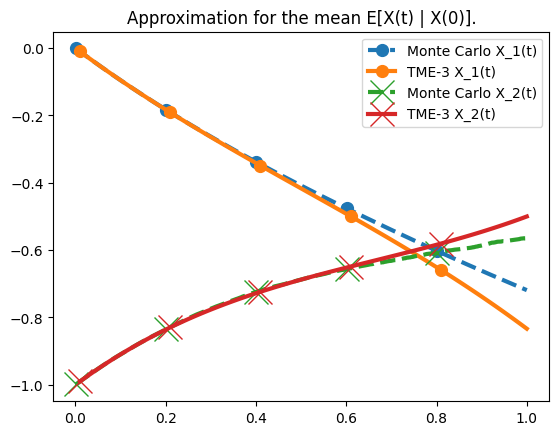

In [8]:
plt.plot(np.linspace(0.001, 1, 1000), m_em[:, 0],
         linewidth=3, marker='.', markevery=200, markersize=17,
         linestyle='--',
         label='Monte Carlo X_1(t)')
plt.plot(T, m_results[:, 0],
         linewidth=3, marker='.', markevery=20, markersize=17,
         label='TME-3 X_1(t)')

plt.plot(np.linspace(0.001, 1, 1000), m_em[:, 1],
         linewidth=3, marker='x', markevery=200, markersize=17,
         linestyle='--',
         label='Monte Carlo X_2(t)')
plt.plot(T, m_results[:, 1],
         linewidth=3, marker='x', markevery=20, markersize=17,
         label='TME-3 X_2(t)')
plt.legend()
_ = plt.title('Approximation for the mean E[X(t) | X(0)].')

Exercise:

Approximate $\mathbb{E}[\log(1 + \exp(X(t))) \mid X(0)]$.